In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

In [2]:
df = pd.read_csv('XRAY.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-07,38.860001,39.080002,38.430000,38.540001,38.232761,2541300
2018-09-10,38.740002,38.799999,38.070000,38.150002,37.845875,2621300
2018-09-11,38.160000,38.520000,37.459999,38.189999,37.885551,5536700
2018-09-12,38.340000,39.020000,38.340000,38.750000,38.441086,3465400
2018-09-13,38.779999,39.000000,38.290001,38.740002,38.431171,2593300


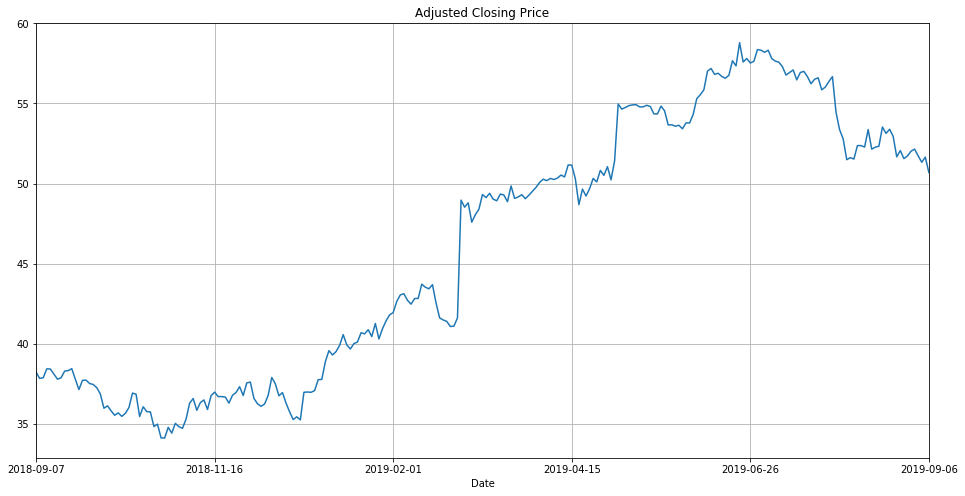

In [4]:
df['Adj Close'].plot(label="XRAY", figsize=(16,8), title="Adjusted Closing Price", grid=True)

In [5]:
window_size = 32 
# Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [6]:
data = df['Adj Close'].values[indices]

In [7]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [8]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [10]:
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [11]:
def test_model(model_name, X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test, df=df, window_size=window_size, ind_split=ind_split, graphs = False):
    
    
    # To know what model we are testing
    print("The model is :" , str(model_name), "\n") 
    
    # Training the model
    model = model_name()
    model.fit(X_train, y_train)
    
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Evaluating the model
    score_train = mean_squared_error(y_pred_train, y_train)
    score_test = mean_squared_error(y_pred, y_test)
    
    print("The MSE on the train set is :", score_train, "\n")
    print("The MSE on the test set is :", score_test, "\n")
    
    
    #If we want to visualize the predictions, set graphs to TRUE
    if(graphs==True):
    
        df_train = df.copy()
        df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
        df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
        df_train['Adj Close Train'] = y_pred_train[:-window_size]
        df_train.plot(label='XRAY', figsize=(16,8), title='Adjusted Closing Price on train data', grid=True)

        # Same for the test
        df_test = df.copy()
        df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
        df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
        df_test['Adj Close Test'] = y_pred
        df_test.plot(label='XRAY', figsize=(16,8), title='Adjusted Closing Price on test data', grid=True)
    
    
    return model

The model is : <class 'xgboost.sklearn.XGBRegressor'> 

[15:56:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


The MSE on the train set is : 0.036988074758097775 

The MSE on the test set is : 11.239311217660024 



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

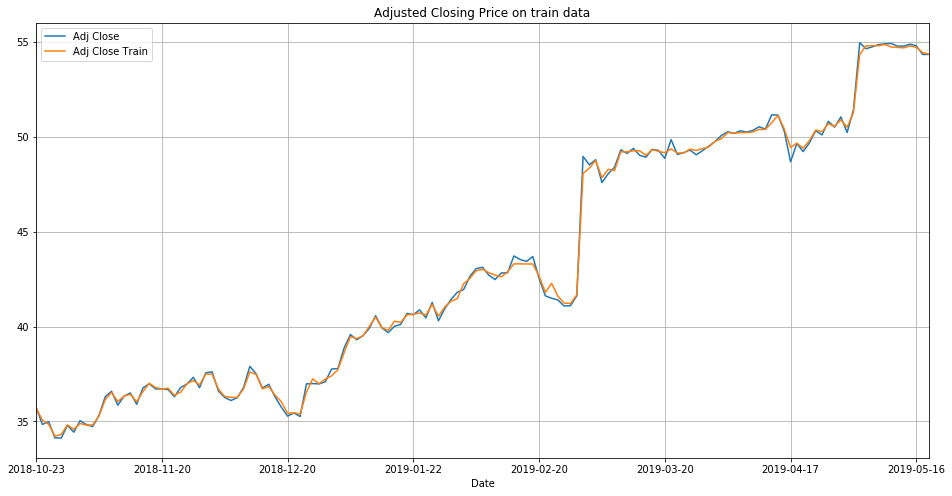

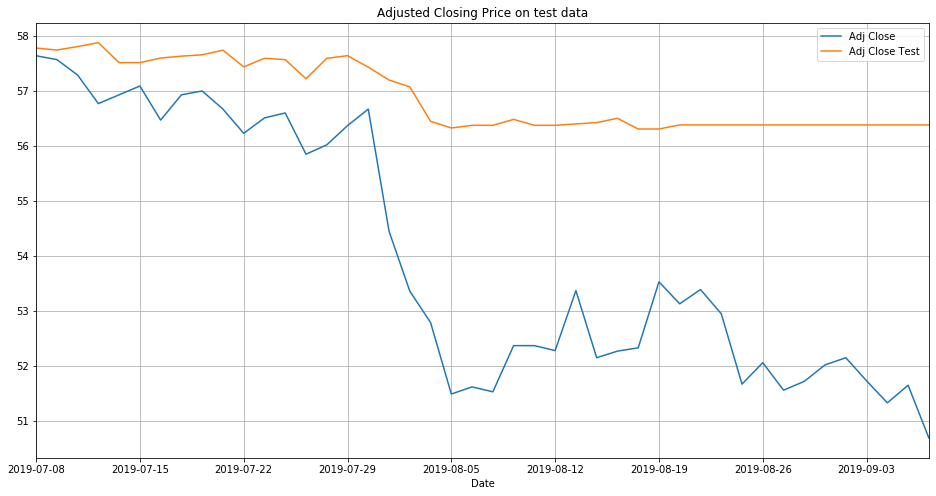

In [12]:
test_model(XGBRegressor, graphs=True)

In [13]:
models = [LinearRegression, Lasso, GradientBoostingRegressor, RandomForestRegressor, XGBRegressor]

In [14]:
for model in models:
    test_model(model)

The model is : <class 'sklearn.linear_model.base.LinearRegression'> 

The MSE on the train set is : 0.5793511756264104 

The MSE on the test set is : 0.7392548977783103 

The model is : <class 'sklearn.linear_model.coordinate_descent.Lasso'> 

The MSE on the train set is : 0.6428802241743912 

The MSE on the test set is : 0.5214576422405571 

The model is : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 

The MSE on the train set is : 0.013089117919186734 

The MSE on the test set is : 7.368688285205454 

The model is : <class 'sklearn.ensemble.forest.RandomForestRegressor'> 

The MSE on the train set is : 0.1590955855905892 

The MSE on the test set is : 7.545867289632284 

The model is : <class 'xgboost.sklearn.XGBRegressor'> 

[15:59:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\streichholzschächtel\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


The MSE on the train set is : 0.036988074758097775 

The MSE on the test set is : 11.239311217660024 

